In [75]:
import os
import logging
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from glob import glob
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM
from lenstools import ConvergenceMap
from lenstools.image.noise import GaussianNoiseGenerator

from src.utils.ConfigData import ConfigData, ConfigAnalysis, CatalogHandler
from src.flatsky.fibonacci_patch import patch_handler

from src.utilities import CosmologySettings, extract_seed_from_directory
from nbodykit.lab import BigFileCatalog

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [4]:
config_file = os.path.join("/lustre/work/akira.tokiwa/Projects/LensingSSC/configs", 'config_data.json')
config_data = ConfigData.from_json(config_file)

config_analysis_file = os.path.join("/lustre/work/akira.tokiwa/Projects/LensingSSC/configs", 'config_analysis.json')
config_analysis = ConfigAnalysis.from_json(config_analysis_file)

In [97]:
cosmo = CosmologySettings(h=0.6774, om=0.309).get_cosmology()

cat_tiled = BigFileCatalog(os.path.join(config_data.tileddir, "usmesh/"), dataset="HEALPIX/")
cat_bigbox = BigFileCatalog(os.path.join(config_data.bigboxdir, "usmesh/"), dataset="HEALPIX/")
nside = cat_tiled.attrs['healpix.nside'][0]
npix =  cat_tiled.attrs['healpix.npix'][0]

vmin, vmax = -0.06, 0.06

patch_size = 10
xsize=2048
reso = patch_size*60/xsize
nbin= 15
lmin, lmax = 300, 3000
lmin_size, lmax_size = np.pi / np.deg2rad(patch_size), np.pi / np.deg2rad(reso / 60)

bins = np.linspace(-4, 4, nbin+1, endpoint=True)
l_edges = np.linspace(lmin, lmax, nbin+1, endpoint=True)

ell = (l_edges[1:] + l_edges[:-1]) / 2
nu = (bins[1:] + bins[:-1]) / 2

/home/akira.tokiwa/.conda/envs/lssc/lib/python3.8/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)
2024-08-27 08:43:40,658 - INFO - Extra arguments to FileType: () {'dataset': 'HEALPIX/'}
2024-08-27 08:43:41,832 - INFO - Extra arguments to FileType: () {'dataset': 'HEALPIX/'}


In [69]:
cat_tiled.attrs['aemitIndex.edges']

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

In [5]:
dir_results_tiled = os.path.join(config_analysis.resultsdir, 'tiled')
dir_results_bigbox = os.path.join(config_analysis.resultsdir, 'bigbox')

# Settings

In [15]:
from matplotlib.patches import Arc
from astropy import cosmology

In [14]:
def plot_setting(save_dir, sboxsize, bboxsize, patch_size):
    # Parameters
    replications = bboxsize // sboxsize

    # Convert opening angle to radians
    opening_angle_rad = np.deg2rad(patch_size)

    # Calculate the extent of the light cone in x and y directions
    extent = bboxsize * np.tan(opening_angle_rad)

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(7, 4))

    # Draw the replicated boxes
    for i in range(replications):
        ax.vlines(x=i * sboxsize, ymin=-bboxsize / 2, ymax=bboxsize / 2, color='tab:blue', linestyle='--')

    for i in range(4):
        ax.hlines(y=(i+0.5) * sboxsize, xmin=0, xmax=bboxsize, color='tab:blue', linestyle='--')
        ax.hlines(y=-(i+0.5) * sboxsize, xmin=0, xmax=bboxsize, color='tab:blue', linestyle='--')

    for i in range(replications):
        for j in range(4):
            rect = plt.Rectangle((i * sboxsize, -sboxsize/2 + j * sboxsize), sboxsize, sboxsize, edgecolor='blue', linestyle='-', fill=True, alpha=0.1)
            ax.add_patch(rect)
            if j != 0:
                rect = plt.Rectangle((i * sboxsize, -sboxsize/2 - j * sboxsize), sboxsize, sboxsize, edgecolor='blue', linestyle='-', fill=True, alpha=0.1)
                ax.add_patch(rect)

    rect = plt.Rectangle((3 * sboxsize, -sboxsize/2), sboxsize, sboxsize, edgecolor='blue', linestyle='-', fill=True, alpha=0.5)
    ax.add_patch(rect)
    ax.text(3 * sboxsize + sboxsize/2, 0, ' small\n box', fontsize=14, color='black', ha='center', va='center')
        
    # Draw the light cone
    x_coords = [0, bboxsize]
    y_coords = [0, extent]
    ax.plot(x_coords, y_coords, color='tab:red')

    x_coords = [0, bboxsize]
    y_coords = [0, -extent]
    ax.plot(x_coords, y_coords, color='tab:red')

    # Add the opening angle arc
    arc = Arc((0, 0), width=bboxsize*1.9, height=1.9*bboxsize, angle=0,
            theta1=-patch_size, theta2=patch_size, color='tab:green')
    ax.add_patch(arc)

    # Add the opening angle annotation
    arc_radius = bboxsize*0.95
    arc_x = arc_radius * np.cos(opening_angle_rad / 2)
    arc_y = arc_radius * np.sin(opening_angle_rad / 2)
    ax.annotate(f'{patch_size}°',
                xy=(arc_x, arc_y),
                xytext=(arc_x - 900, arc_y - 0),
                arrowprops=dict(facecolor='black', shrink=0.05),
                fontsize=18,
                color='black')

    # Set limits and labels
    ax.set_xlim(0, bboxsize)
    ax.set_ylim(-bboxsize / 4, bboxsize / 4)
    ax.set_xlabel('Distance (Mpc/h)', fontsize=14)
    ax.set_ylabel('Distance (Mpc/h)', fontsize=14)
    #ax.set_title('Concept Figure of a Light Cone Configuration')


    # Create a secondary x-axis for redshift
    secax = ax.secondary_xaxis('top')
    secax.set_xlabel('Redshift', fontsize=14)
    redshift_ticks = [0.5, 1.0, 2.0, 3.0]
    distance_ticks = [cosmo.comoving_distance(z).value * cosmo.h for z in redshift_ticks]
    secax.set_xticks(distance_ticks)
    secax.set_xticklabels(redshift_ticks)

    # save the figure
    plt.savefig(f'{save_dir}/light_cone_configuration.png', bbox_inches='tight')

In [16]:
# Define the function
def lens_efficiency(chi, cosmo, zs):
    """Compute the weight function for weak lensing convergence."""
    chis = cosmo.comoving_distance(zs).value  # Mpc
    z = cosmology.z_at_value(cosmo.comoving_distance, chi * u.Mpc).value
    dchi = (1 - chi / chis).clip(0)
    return (1 + z) * chi * dchi  # 1/Mpc

def lensarray(cosmo, zs, bins=50):
    # Create a range of chi values
    chi_values = np.linspace(0.1, cosmo.comoving_distance(zs).value, bins)
    lens_efficiencies = lens_efficiency(chi_values, cosmo, zs)
    lens_efficiencies = lens_efficiencies / np.max(lens_efficiencies)
    return chi_values*cosmo.h, lens_efficiencies

def plot_lenseff(save_dir, zs_list=[0.5, 1.0, 2.0, 3.0]):
    fig, ax = plt.subplots(figsize=(7, 4))

    for zs in zs_list:
        chi_values, lens_efficiency_normalized = lensarray(cosmo, zs)
        ax.plot(chi_values, lens_efficiency_normalized, label=f'z={zs}')

    ax.set_xlabel('Comoving Distance (Mpc/h)')
    ax.set_ylabel('Normalized Lens Efficiency')
    ax.set_title('Countribution of different redshifts to lensing')
    ax.legend()

    # Create a secondary x-axis for redshift
    secax = ax.secondary_xaxis('top')
    secax.set_xlabel('z')
    distance_ticks = [cosmo.comoving_distance(z).value * cosmo.h for z in zs_list]
    secax.set_xticks(distance_ticks)
    secax.set_xticklabels(zs_list)

    ax.grid(True)

    # save the figure
    plt.savefig(f'{save_dir}/lensefficiency.png', bbox_inches='tight')

# load Mass sheet

In [50]:
def load_delta(path):
    sample = np.load(path)
    delta = sample['delta']
    chi1, chi2 = sample['chi1'][0], sample['chi2'][0]
    return delta, chi1, chi2

def extract_seed(subdir_path):
    seed_number = subdir_path.split('_')[4][1:]
    if "rfof" in os.path.basename(subdir_path).split('_'):
        seed_number = subdir_path.split('_')[-10][1:]
    return seed_number

In [48]:
data_dir = "/lustre/work/akira.tokiwa/Projects/LensingSSC/data/"
mass_files = glob(os.path.join(data_dir, "*", "mass_sheets", 'delta-sheet-50.npz'))

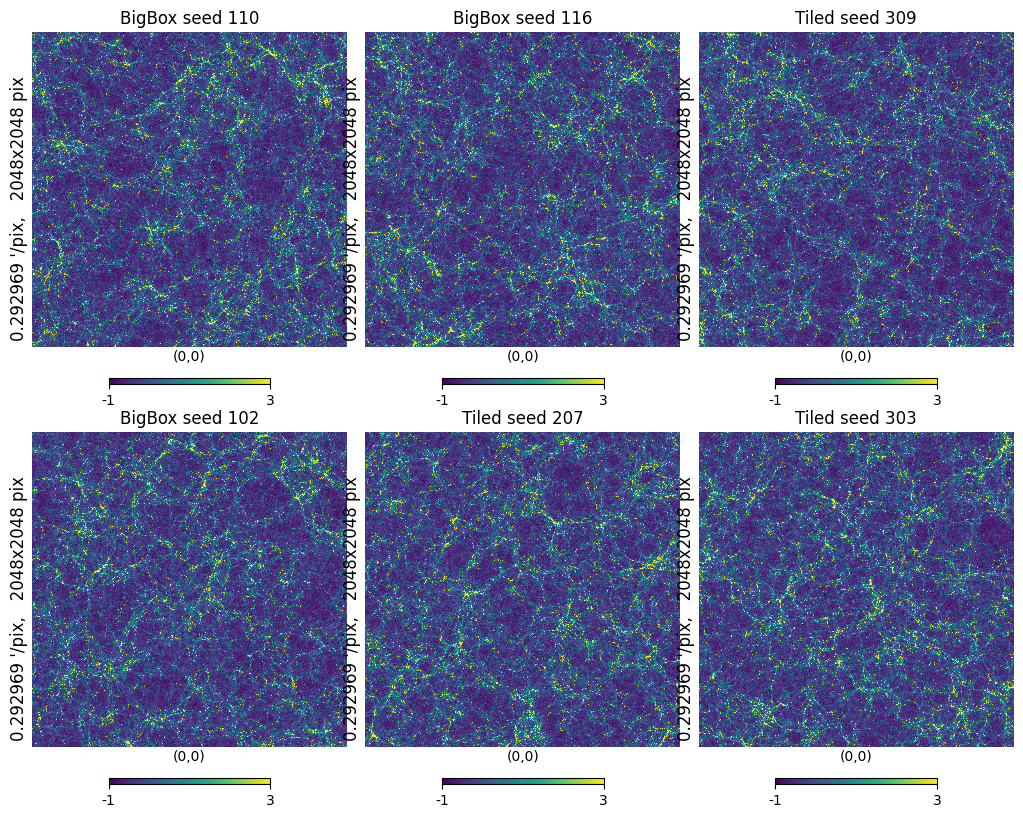

In [56]:
fig = plt.figure(figsize=(10, 8))

for i in range(6):
    mass_file = mass_files[i]
    delta, chi1, chi2 = load_delta(mass_file)
    subdir_path = mass_file.split("/")[-3]
    seed_number = extract_seed(subdir_path)
    title = f"Tiled seed {seed_number}"
    if "rfof" in subdir_path.split('_'):
        title = f"BigBox seed {seed_number}"
    hp.gnomview(delta, rot=[0, 0], reso=reso, xsize=xsize, title=title, sub=(2, 3, i+1), min=-1, max=3, fig=fig, nest=True)

plt.show()

# load data

In [62]:
data_dir = "/lustre/work/akira.tokiwa/Projects/LensingSSC/data/"
kappa_files = glob(os.path.join(data_dir, "rfof*", "kappa", 'kappa_zs2.0*.fits'))

In [64]:
kappa_tiled = hp.read_map(kappa_files[2])
kappa_bigbox = hp.read_map(kappa_files[0])

2024-08-27 06:39:15,316 - INFO - NSIDE = 8192
2024-08-27 06:39:15,327 - INFO - ORDERING = RING in fits file
2024-08-27 06:39:15,338 - INFO - INDXSCHM = IMPLICIT
2024-08-27 06:39:42,616 - INFO - NSIDE = 8192
2024-08-27 06:39:42,627 - INFO - ORDERING = RING in fits file
2024-08-27 06:39:42,638 - INFO - INDXSCHM = IMPLICIT


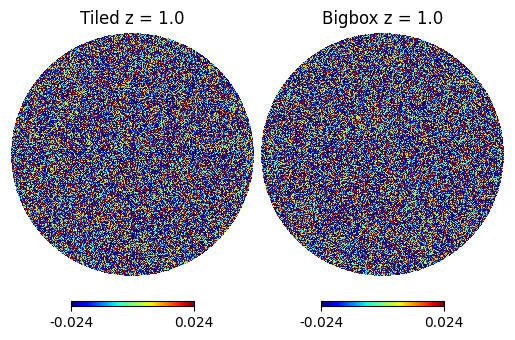

In [65]:
fig = plt.figure(figsize=(5, 5))
hp.orthview(kappa_tiled, fig=1, title='Tiled z = 1.0', sub=(1, 2, 1), nest=True, cmap="jet", min=vmin, max=vmax, half_sky=True)
hp.orthview(kappa_bigbox, fig=1, title='Bigbox z = 1.0', sub=(1, 2, 2), nest=True, cmap="jet", min=vmin, max=vmax, half_sky=True)

In [79]:
kappa_files = glob(os.path.join(data_dir, "proc*", "kappa", 'kappa_zs2.0_*.fits'))

# Patch Sky

In [126]:
center = [30, 0]

patch_tiled = hp.gnomview(kappa_tiled, rot=center, reso=reso, xsize=xsize, return_projected_map=True, no_plot=True, nest=True)
patch_bigbox = hp.gnomview(kappa_bigbox, rot=center, reso=reso, xsize=xsize, return_projected_map=True, no_plot=True, nest=True)

patches = []
labels = []
for i in range(4):
    kappa = hp.read_map(kappa_files[i])
    patch = hp.gnomview(kappa, rot=center, reso=reso, xsize=xsize, return_projected_map=True, no_plot=True, nest=True)
    patches.append(patch)
    labels.append("Tiled seed" + extract_seed_from_directory(kappa_files[i].rsplit('/', 2)[0]))

2024-08-27 09:01:22,019 - INFO - NSIDE = 8192
2024-08-27 09:01:22,030 - INFO - ORDERING = RING in fits file
2024-08-27 09:01:22,041 - INFO - INDXSCHM = IMPLICIT
2024-08-27 09:01:42,943 - INFO - NSIDE = 8192
2024-08-27 09:01:42,954 - INFO - ORDERING = RING in fits file
2024-08-27 09:01:42,965 - INFO - INDXSCHM = IMPLICIT
2024-08-27 09:02:03,817 - INFO - NSIDE = 8192
2024-08-27 09:02:03,827 - INFO - ORDERING = RING in fits file
2024-08-27 09:02:03,838 - INFO - INDXSCHM = IMPLICIT
2024-08-27 09:02:24,180 - INFO - NSIDE = 8192
2024-08-27 09:02:24,190 - INFO - ORDERING = RING in fits file
2024-08-27 09:02:24,192 - INFO - INDXSCHM = IMPLICIT


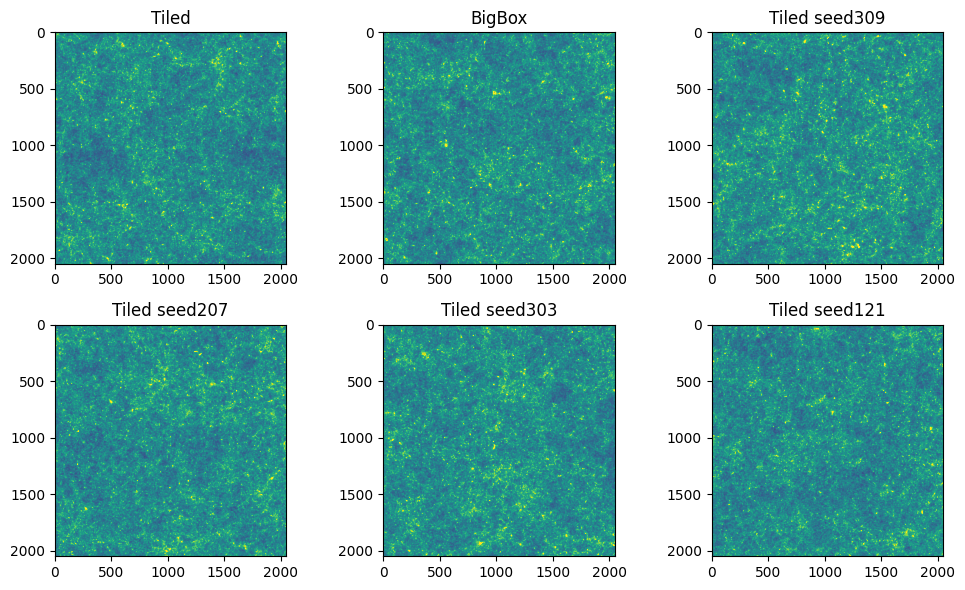

In [127]:
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
titles = ["Tiled", "BigBox"] + labels 
images = [patch_tiled, patch_bigbox] + patches

for ax, title, img in zip(axes.flatten(), titles, images):
    ax.imshow(img, vmin=vmin*2, vmax=vmax*2)
    ax.set_title(title)

plt.tight_layout()
plt.show()

In [88]:
convs = []
for image in images:
    conv = ConvergenceMap(image, angle=patch_size*u.deg)
    convs.append(conv)

In [90]:
class ShapeNoiseGenerator():
    def __init__(self, xsize, reso, ngal):
        self.xsize = xsize
        self.reso = reso
        self.ngal = ngal

    def generate(self, seed=np.random.randint(0, 1000)):
        np.random.seed(seed)
        sigma = 0.3 / (reso * np.sqrt(self.ngal))
        noise_map = np.random.normal(loc=0, scale=sigma, size=(self.xsize, self.xsize))
        return noise_map
    
def addNoise_smooth(patch_pixels, noise_map, patch_size=patch_size, scale_angle=2):
    convergence_map = ConvergenceMap(patch_pixels+noise_map, angle=patch_size * u.deg)
    convergence_map.smooth(scale_angle * u.arcmin, inplace=True)
    return convergence_map

In [94]:
hp.nside2pixarea(nside) * 2

3.120891902436607e-08

In [91]:
noise_generator = ShapeNoiseGenerator(xsize, reso, ngal=30)

In [95]:
conv_ns = []
for conv in convs:
    noise_map = noise_generator.generate()
    conv_ns.append(addNoise_smooth(conv.data.data, noise_map, patch_size=patch_size, scale_angle=hp.nside2pixarea(nside) * 8))

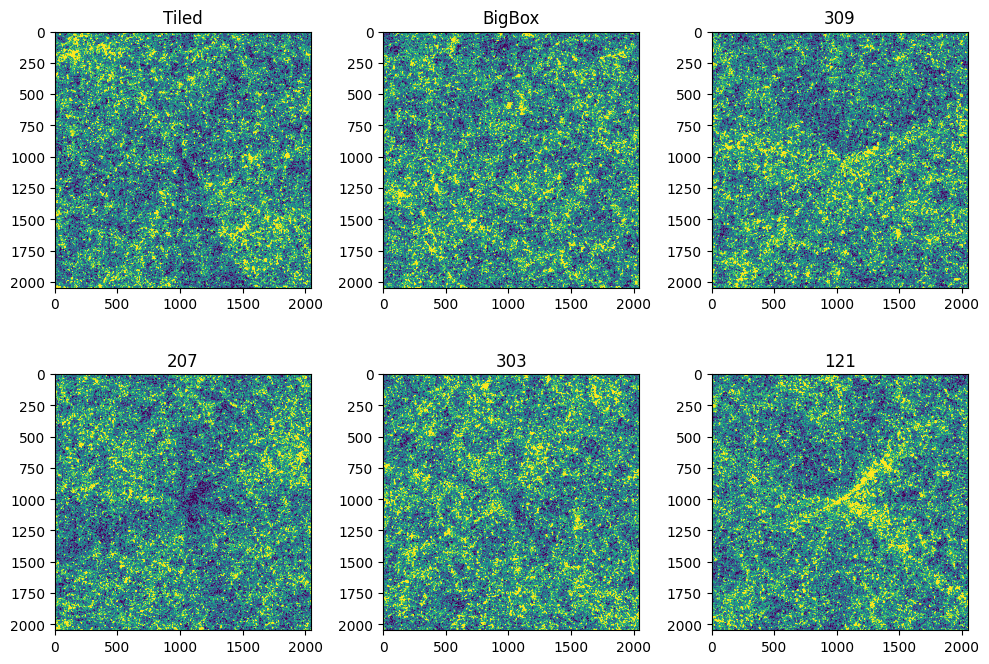

In [98]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(10, 7))
images = [conv.data.data for conv in conv_ns]

for ax, title, img in zip(axes.flatten(), titles, images):
    ax.imshow(img, vmin=vmin, vmax=vmax)
    ax.set_title(title)

plt.tight_layout()
plt.show()

# power Spectrum

In [102]:
hf = np.load("/lustre/work/akira.tokiwa/Projects/LensingSSC/results/halofit/kappa_zs2.0_Clkk_ell_0_3000.npz")
ell_hf, cl_hf = hf['ell'][lmin-1:], hf['clkk'][lmin-1:]

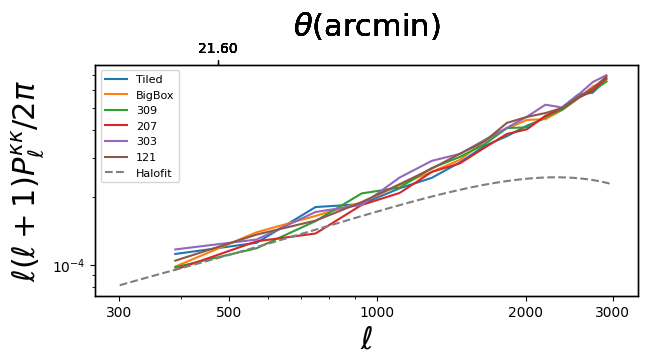

In [106]:
fig, ax = plt.subplots(1, 1, figsize=(7, 3))

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown"]
for conv, color, label in zip(conv_ns, colors, titles):
    conv.plotPowerSpectrum(l_edges, fig=fig, ax=ax, color=color, label=label)

ax.plot(ell_hf, ell_hf * (ell_hf+1) * cl_hf / (2*np.pi), label="Halofit", color="tab:gray", linestyle="--")

ax.set_xticks([300, 500, 1000, 2000, 3000])
ax.set_xticklabels([300, 500, 1000, 2000, 3000])

ax.legend(fontsize=8)
plt.show()

In [107]:
cls = []
for conv in conv_ns:
    ell, cl = conv.powerSpectrum(l_edges)
    cls.append(cl)

cl = np.vstack(cls)
corr = np.corrcoef(cl, rowvar=False)
cov = np.cov(cl, rowvar=False)

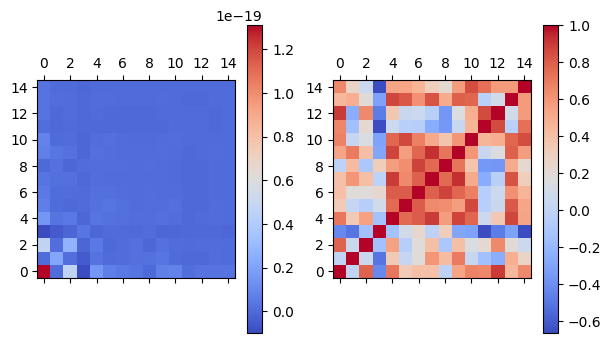

In [112]:
# plot the covariance matrix
fig, ax = plt.subplots(1, 2, figsize=(7, 4))
cax = ax[0].matshow(cov, cmap='coolwarm')
fig.colorbar(cax)
ax[0].invert_yaxis()

cax = ax[1].matshow(corr, cmap='coolwarm')
fig.colorbar(cax)
ax[1].invert_yaxis()

plt.show()

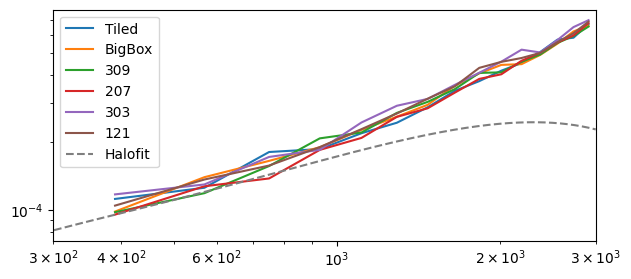

In [115]:
fig = plt.figure(figsize=(7, 3))

for i, cl_tmp in enumerate(cl):
    plt.plot(ell, ell * (ell+1) * cl_tmp/ (2*np.pi), label=titles[i])

plt.plot(ell_hf, ell_hf * (ell_hf+1) * cl_hf / (2*np.pi), label="Halofit", color="tab:gray", linestyle="--")
plt.xscale("log")
plt.yscale("log")
plt.xlim(lmin, lmax)
#plt.ylim(1e-4, 1e-3)
plt.legend()
plt.show()

# Peaks

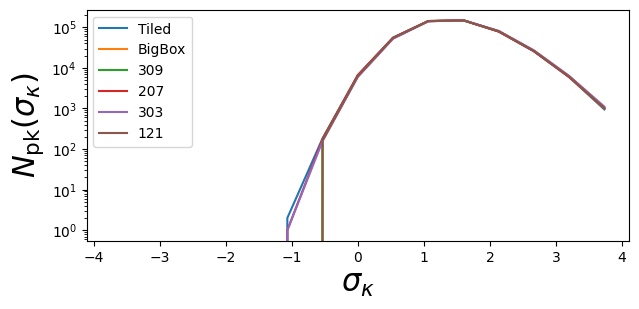

In [118]:
fig, ax = plt.subplots(1, 1, figsize=(7, 3))

for conv, color, label in zip(conv_ns, colors, titles):
    conv.peakHistogram(bins, norm=True,fig=fig, ax=ax, color=color, label=label)

ax.legend()
plt.show()

In [119]:
def exclude_edges(heights, positions, patch_size_deg, xsize, return_index=True):
    tmp_positions = positions.value * xsize / patch_size_deg
    mask = (tmp_positions[:, 0] > 0) & (tmp_positions[:, 0] < xsize-1) & (tmp_positions[:, 1] > 0) & (tmp_positions[:, 1] < xsize-1)
    if return_index:
        return heights[mask], tmp_positions[mask].astype(int)
    else:
        return heights[mask], positions[mask]
    
def get_peaks(conv, bins, patch_size, xsize):
    heights, positions = conv.locatePeaks(bins, norm=True)
    heights, positions = exclude_edges(heights, positions, patch_size, xsize)
    return np.histogram(heights, bins=bins)[0]

In [120]:
peaks = []
for conv in conv_ns:
    peaks.append(get_peaks(conv, bins, patch_size, xsize))

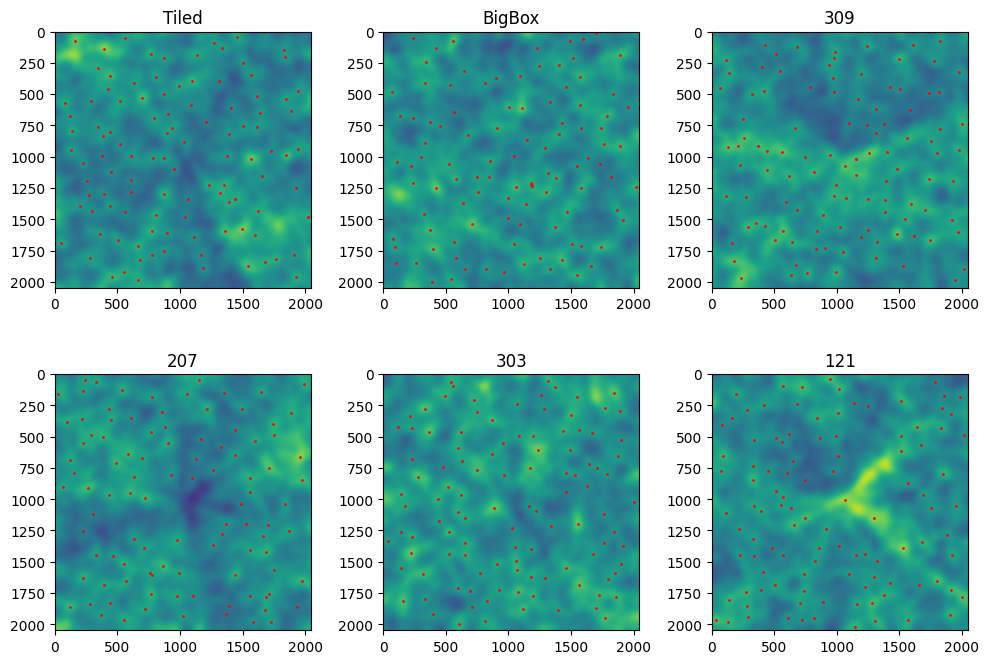

In [121]:

fig, axes = plt.subplots(2, 3, figsize=(10, 7))
for ax, title, conv in zip(axes.flatten(), titles, conv_ns):
    heights, positions = conv.smooth(10*u.arcmin).locatePeaks(bins, norm=True)
    heights, positions = exclude_edges(heights, positions, patch_size, xsize)
    ax.imshow(conv.smooth(10*u.arcmin).data, vmin=vmin, vmax=vmax)

    ax.scatter(positions[:, 0], positions[:, 1], c="r", s=1)
    ax.set_title(title)

plt.tight_layout()
plt.show()

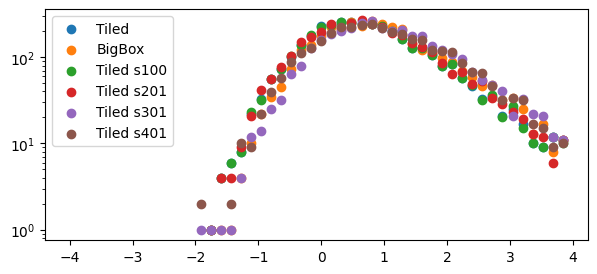

In [59]:
fig = plt.figure(figsize=(7, 3))
plt.scatter(bins[:-1], peak_tiled, label="Tiled")
plt.scatter(bins[:-1], peak_bigbox, label="BigBox")
plt.scatter(bins[:-1], peak_tiled_s100, label="Tiled s100")
plt.scatter(bins[:-1], peak_tiled_s201, label="Tiled s201")
plt.scatter(bins[:-1], peak_tiled_s301, label="Tiled s301")
plt.scatter(bins[:-1], peak_tiled_s401, label="Tiled s401")
plt.legend()
plt.yscale("log")
plt.show()

## PDF

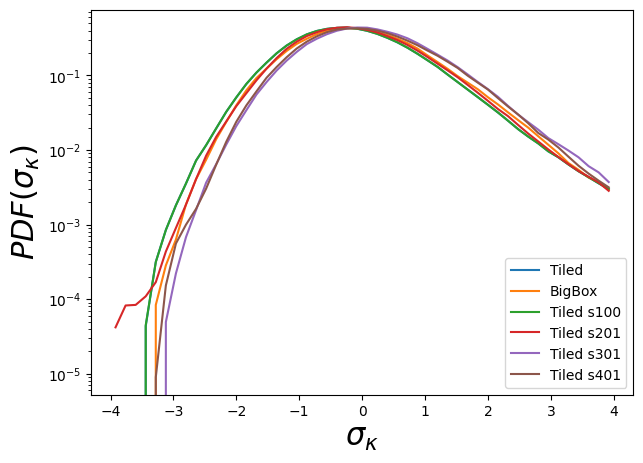

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

conv_noisy_smooth_tiled.plotPDF(bins, norm=True,fig=fig, ax=ax,label="Tiled", color="tab:blue")
conv_noisy_smooth_bigbox.plotPDF(bins, norm=True,fig=fig, ax=ax,label="BigBox", color="tab:orange")
conv_noisy_smooth_tiled_s100.plotPDF(bins, norm=True,fig=fig, ax=ax,label="Tiled s100", color="tab:green")
conv_noisy_smooth_tiled_s201.plotPDF(bins, norm=True,fig=fig, ax=ax,label="Tiled s201", color="tab:red")
conv_noisy_smooth_tiled_s301.plotPDF(bins, norm=True,fig=fig, ax=ax,label="Tiled s301", color="tab:purple")
conv_noisy_smooth_tiled_s401.plotPDF(bins, norm=True,fig=fig, ax=ax,label="Tiled s401", color="tab:brown")

ax.set_yscale("log")
ax.legend()
plt.show()

In [71]:
nu_tiled, pdf_tiled = conv_noisy_smooth_tiled.pdf(bins, norm=True)
nu_bigbox, pdf_bigbox = conv_noisy_smooth_bigbox.pdf(bins, norm=True)

nu_tiled_s100, pdf_tiled_s100 = conv_noisy_smooth_tiled_s100.pdf(bins, norm=True)
nu_tiled_s201, pdf_tiled_s201 = conv_noisy_smooth_tiled_s201.pdf(bins, norm=True)
nu_tiled_s301, pdf_tiled_s301 = conv_noisy_smooth_tiled_s301.pdf(bins, norm=True)
nu_tiled_s401, pdf_tiled_s401 = conv_noisy_smooth_tiled_s401.pdf(bins, norm=True)

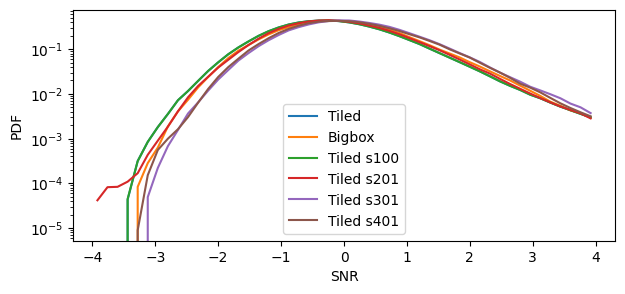

In [72]:
fig = plt.figure(figsize=(7, 3))
plt.plot(nu_tiled, pdf_tiled, label='Tiled')
plt.plot(nu_bigbox, pdf_bigbox, label='Bigbox')
plt.plot(nu_tiled_s100, pdf_tiled_s100, label='Tiled s100')
plt.plot(nu_tiled_s201, pdf_tiled_s201, label='Tiled s201')
plt.plot(nu_tiled_s301, pdf_tiled_s301, label='Tiled s301')
plt.plot(nu_tiled_s401, pdf_tiled_s401, label='Tiled s401')
plt.xlabel('SNR')
plt.ylabel('PDF')
plt.yscale('log')
plt.legend()

## bispectrum

In [63]:
ell, bseq_tiled = conv_noisy_smooth_tiled.bispectrum(l_edges, configuration='equilateral')
ell, bseq_bigbox = conv_noisy_smooth_bigbox.bispectrum(l_edges, configuration='equilateral')

ell, bseq_tiled_s100 = conv_noisy_smooth_tiled_s100.bispectrum(l_edges, configuration='equilateral')
ell, bseq_tiled_s201 = conv_noisy_smooth_tiled_s201.bispectrum(l_edges, configuration='equilateral')
ell, bseq_tiled_s301 = conv_noisy_smooth_tiled_s301.bispectrum(l_edges, configuration='equilateral')
ell, bseq_tiled_s401 = conv_noisy_smooth_tiled_s401.bispectrum(l_edges, configuration='equilateral')

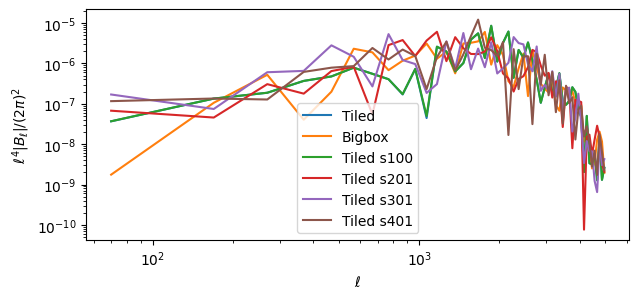

In [64]:
fig = plt.figure(figsize=(7, 3))
plt.plot(ell, np.abs(bseq_tiled) * ell**4 / (2*np.pi)**2, label='Tiled')
plt.plot(ell, np.abs(bseq_bigbox) * ell**4 / (2*np.pi)**2, label='Bigbox')
plt.plot(ell, np.abs(bseq_tiled_s100) * ell**4 / (2*np.pi)**2, label='Tiled s100')
plt.plot(ell, np.abs(bseq_tiled_s201) * ell**4 / (2*np.pi)**2, label='Tiled s201')
plt.plot(ell, np.abs(bseq_tiled_s301) * ell**4 / (2*np.pi)**2, label='Tiled s301')
plt.plot(ell, np.abs(bseq_tiled_s401) * ell**4 / (2*np.pi)**2, label='Tiled s401')

plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell^4|B_{\ell}|/(2\pi)^2$')
plt.xscale('log')
plt.yscale('log')

plt.legend()
plt.show()

In [65]:
ell, bssq_tiled = conv_noisy_smooth_tiled.bispectrum(l_edges, configuration='folded', ratio=0.1)
ell, bssq_bigbox = conv_noisy_smooth_bigbox.bispectrum(l_edges, configuration='folded', ratio=0.1)

ell, bssq_tiled_s100 = conv_noisy_smooth_tiled_s100.bispectrum(l_edges, configuration='folded', ratio=0.1)
ell, bssq_tiled_s201 = conv_noisy_smooth_tiled_s201.bispectrum(l_edges, configuration='folded', ratio=0.1)
ell, bssq_tiled_s301 = conv_noisy_smooth_tiled_s301.bispectrum(l_edges, configuration='folded', ratio=0.1)
ell, bssq_tiled_s401 = conv_noisy_smooth_tiled_s401.bispectrum(l_edges, configuration='folded', ratio=0.1)

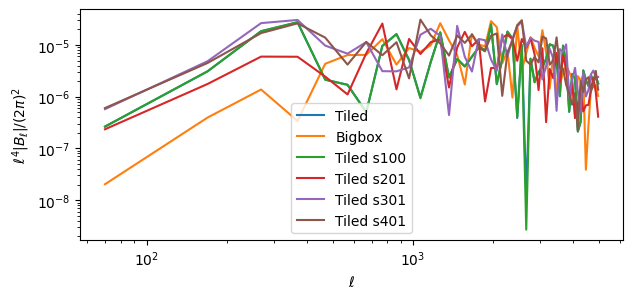

In [66]:
fig = plt.figure(figsize=(7, 3))
plt.plot(ell, np.abs(bssq_tiled) * ell**4 / (2*np.pi)**2, label='Tiled')
plt.plot(ell, np.abs(bssq_bigbox) * ell**4 / (2*np.pi)**2, label='Bigbox')
plt.plot(ell, np.abs(bssq_tiled_s100) * ell**4 / (2*np.pi)**2, label='Tiled s100')
plt.plot(ell, np.abs(bssq_tiled_s201) * ell**4 / (2*np.pi)**2, label='Tiled s201')
plt.plot(ell, np.abs(bssq_tiled_s301) * ell**4 / (2*np.pi)**2, label='Tiled s301')
plt.plot(ell, np.abs(bssq_tiled_s401) * ell**4 / (2*np.pi)**2, label='Tiled s401')

plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell^4|B_{\ell}|/(2\pi)^2$')
plt.xscale('log')
plt.yscale('log')

plt.legend()
plt.show()

# Full data matrix

In [12]:
hf = np.load("/lustre/work/akira.tokiwa/Projects/LensingSSC/results/halofit/kappa_zs1.0_Clkk_ell_0_3000.npz")
ell_hf, cl_hf = hf['ell'][lmin-1:], hf['clkk'][lmin-1:]

In [13]:
ell_idx = np.digitize(ell_hf, l_edges, right=True)
cl_hf = np.bincount(ell_idx, weights=cl_hf)
ell_bincount = np.bincount(ell_idx)
cl_hf = (cl_hf/ell_bincount)[1:]

/var/tmp/pbs.276109.idark/ipykernel_77228/1226910294.py:4: RuntimeWarning: invalid value encountered in true_divide
  cl_hf = (cl_hf/ell_bincount)[1:]


In [6]:
def normalize_peak(peak):
    return (peak.T/np.sum(peak, axis=1)).T

def dimensionless_cl(cl, ell):
    return ell * (ell+1) * cl / (2*np.pi)

def dimiensionless_bispectrum(bispec, ell):
    return bispec * ell**4 / (2*np.pi)**2

In [7]:
datadir="/lustre/work/akira.tokiwa/Projects/LensingSSC/data"
datas = glob(f"{datadir}/*/flat/*zs1.0*.npy")
datas.sort()
datas.pop(-1)

'/lustre/work/akira.tokiwa/Projects/LensingSSC/data/rfof_proc4096_nc1024_size625_nsteps60lin_ldr0_rcvtrue_fstnone_pnf2_lnf2_s100_dhf1.0000_tiled0.20_fll_elllim_10000_npix_8192_rfofkdt_8_LCDM_10tiled/flat/analysis_eqsqclpdpm_zs1.0_sl2_ngal30.npy'

In [8]:
data_bigbox = np.load(datas[-2])
eq_bigbox, sq_bigbox, clkk_bigbox, pdf_bigbox, peak_bigbox, minima_bigbox = np.split(data_bigbox, 6, axis=1)
eq_bigbox = dimiensionless_bispectrum(eq_bigbox, ell)
sq_bigbox = dimiensionless_bispectrum(sq_bigbox, ell)
clkk_bigbox = dimensionless_cl(clkk_bigbox, ell)
peak_bigbox = normalize_peak(peak_bigbox)
minima_bigbox = normalize_peak(minima_bigbox)
data_bigbox = np.hstack([eq_bigbox, sq_bigbox, clkk_bigbox, pdf_bigbox, peak_bigbox, minima_bigbox])

cov_ell_bigbox = np.cov(data_bigbox[:, :nbin*3], rowvar=False)
cov_nu_bigbox = np.cov(data_bigbox[:, nbin*3:], rowvar=False)

diag_bigbox = np.diag(np.cov(data_bigbox, rowvar=False))
corr_bigbox = np.corrcoef(data_bigbox, rowvar=False)
#mean_bigbox = np.mean(data_bigbox, axis=0)
std_bigbox = np.std(data_bigbox, axis=0)
#eq_bigbox, sq_bigbox, clkk_bigbox, pdf_bigbox, peak_bigbox, minima_bigbox = np.split(mean_bigbox, 6)
eq_std_bigbox, sq_std_bigbox, clkk_std_bigbox, pdf_std_bigbox, peak_std_bigbox, minima_std_bigbox = np.split(std_bigbox, 6)

datas.pop(-1)

'/lustre/work/akira.tokiwa/Projects/LensingSSC/data/rfof_proc262144_nc8192_size5000_nsteps60lin_ldr0_rcvtrue_fstnone_pnf2_lnf2_s100_dhf1.0000_tiled0.20_fll_elllim_10000_npix_8192_rfofkdt_8/flat/analysis_eqsqclpdpm_zs1.0_sl2_ngal30.npy'

In [9]:
data_tiled = np.vstack([np.load(data) for data in datas])
eq_tiled, sq_tiled, clkk_tiled, pdf_tiled, peak_tiled, minima_tiled = np.split(data_tiled, 6, axis=1)
eq_tiled = dimiensionless_bispectrum(eq_tiled, ell)
sq_tiled = dimiensionless_bispectrum(sq_tiled, ell)
clkk_tiled = dimensionless_cl(clkk_tiled, ell)
peak_tiled = normalize_peak(peak_tiled)
minima_tiled = normalize_peak(minima_tiled)
data_tiled = np.hstack([eq_tiled, sq_tiled, clkk_tiled, pdf_tiled, peak_tiled, minima_tiled])

diags_tiled = [np.diag(np.cov(data, rowvar=False)) for data in np.split(data_tiled, len(datas), axis=0)]
diags_std_tiled = np.std(diags_tiled, axis=0)

cov_ell_tiled = np.cov(data_tiled[:, :nbin*3], rowvar=False)
cov_nu_tiled = np.cov(data_tiled[:, nbin*3:], rowvar=False)

diag_tiled = np.diag(np.cov(data_tiled, rowvar=False))
corr_tiled = np.corrcoef(data_tiled, rowvar=False)
#mean_tiled = np.mean(data_tiled, axis=0)
std_tiled = np.std(data_tiled, axis=0)
#eq_tiled, sq_tiled, clkk_tiled, pdf_tiled, peak_tiled, minima_tiled = np.split(mean_tiled, 6)
eq_std_tiled, sq_std_tiled, clkk_std_tiled, pdf_std_tiled, peak_std_tiled, minima_std_tiled = np.split(std_tiled, 6)

In [10]:
data_tiled_s100 = np.load(f"{datadir}/proc1024_nc1024_size625_nsteps60_s100_10tiled/flat/analysis_eqsqclpdpm_zs1.0_s100_sl2_ngal30.npy")
eq_tiled_s100, sq_tiled_s100, clkk_tiled_s100, pdf_tiled_s100, peak_tiled_s100, minima_tiled_s100 = np.split(data_tiled_s100, 6, axis=1)
eq_tiled_s100 = dimiensionless_bispectrum(eq_tiled_s100, ell)
sq_tiled_s100 = dimiensionless_bispectrum(sq_tiled_s100, ell)
clkk_tiled_s100 = dimensionless_cl(clkk_tiled_s100, ell)
peak_tiled_s100 = normalize_peak(peak_tiled_s100)
minima_tiled_s100 = normalize_peak(minima_tiled_s100)
data_tiled_s100 = np.hstack([eq_tiled_s100, sq_tiled_s100, clkk_tiled_s100, pdf_tiled_s100, peak_tiled_s100, minima_tiled_s100])

diag_tiled_s100 = np.diag(np.cov(data_tiled_s100, rowvar=False))
corr_tiled_s100 = np.corrcoef(data_tiled_s100, rowvar=False)
#mean_tiled_s100 = np.mean(data_tiled_s100, axis=0)
#eq_tiled_s100, sq_tiled_s100, clkk_tiled_s100, pdf_tiled_s100, peak_tiled_s100, minima_tiled_s100 = np.split(mean_tiled_s100, 6)

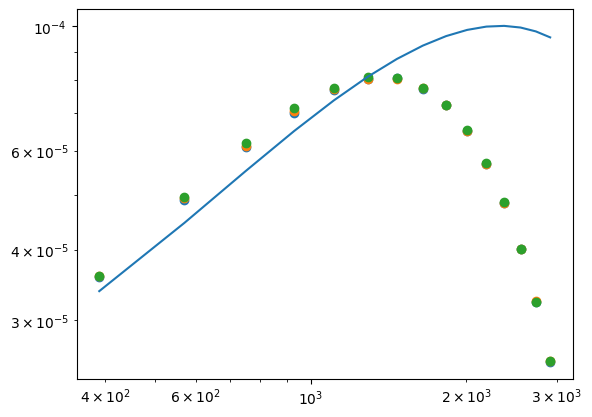

In [15]:
plt.scatter(ell, np.mean(clkk_tiled_s100, axis=0))
plt.scatter(ell, np.mean(clkk_tiled, axis=0))
plt.scatter(ell, np.mean(clkk_bigbox, axis=0))
plt.plot(ell,  dimensionless_cl(cl_hf, ell), label="Halofit")
plt.xscale("log")
plt.yscale("log")
plt.show()

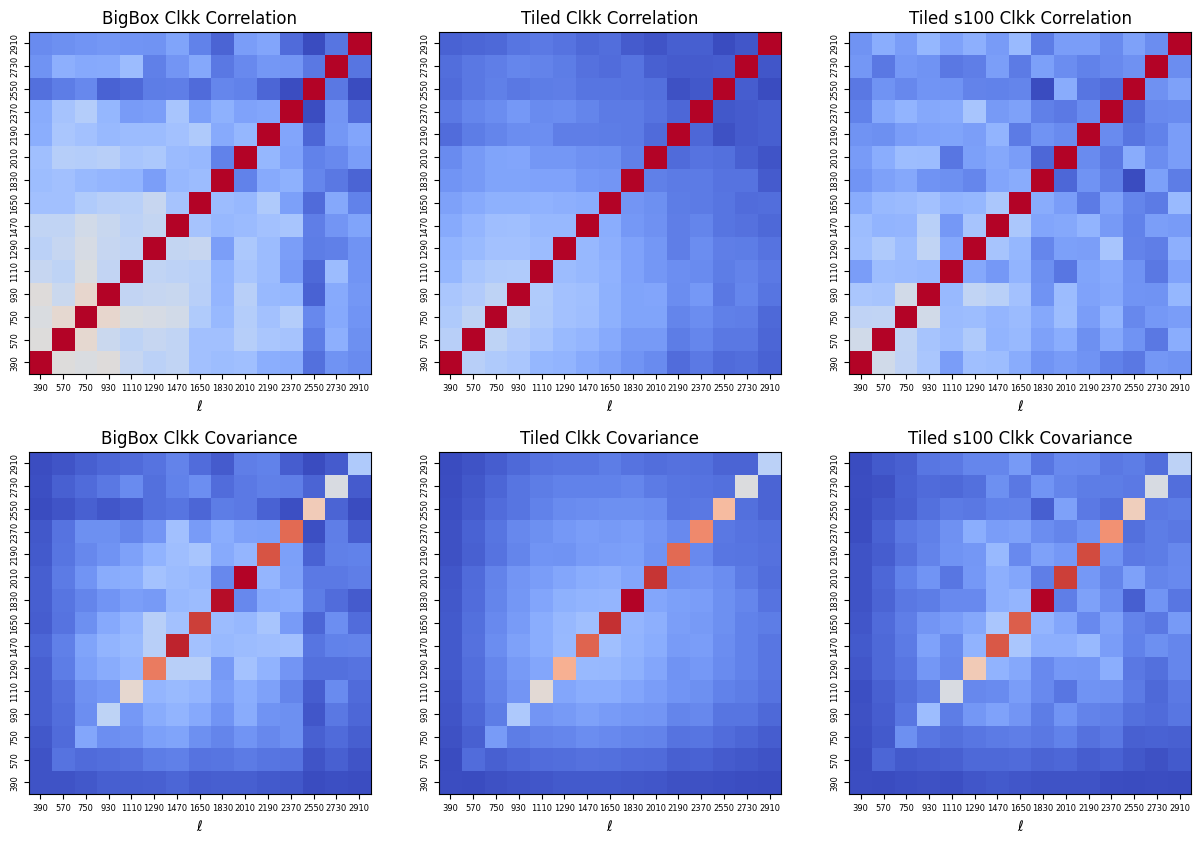

In [16]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

ax[0, 0].imshow(np.corrcoef(clkk_bigbox, rowvar=False), cmap='coolwarm')
ax[0, 0].set_title("BigBox Clkk Correlation")
ax[0, 1].imshow(np.corrcoef(clkk_tiled, rowvar=False), cmap='coolwarm')
ax[0, 1].set_title("Tiled Clkk Correlation")
ax[0, 2].imshow(np.corrcoef(clkk_tiled_s100, rowvar=False), cmap='coolwarm')
ax[0, 2].set_title("Tiled s100 Clkk Correlation")

ax[1, 0].imshow(np.cov(clkk_bigbox, rowvar=False)/np.outer(cl_hf, cl_hf), cmap='coolwarm')
ax[1, 0].set_title("BigBox Clkk Covariance")
ax[1, 1].imshow(np.cov(clkk_tiled, rowvar=False)/np.outer(cl_hf, cl_hf), cmap='coolwarm')
ax[1, 1].set_title("Tiled Clkk Covariance")
ax[1, 2].imshow(np.cov(clkk_tiled_s100, rowvar=False)/np.outer(cl_hf, cl_hf), cmap='coolwarm')
ax[1, 2].set_title("Tiled s100 Clkk Covariance")

tick_positions = [i for i in range(nbin)]
for axes in ax.flatten():
    axes.set_xlabel(r"$\ell$")
    axes.set_xticks(tick_positions, ell.astype(np.int32), fontsize=6)
    axes.set_yticks(tick_positions, ell.astype(np.int32), fontsize=6, rotation=90, va='center')
    axes.invert_yaxis()

plt.show()

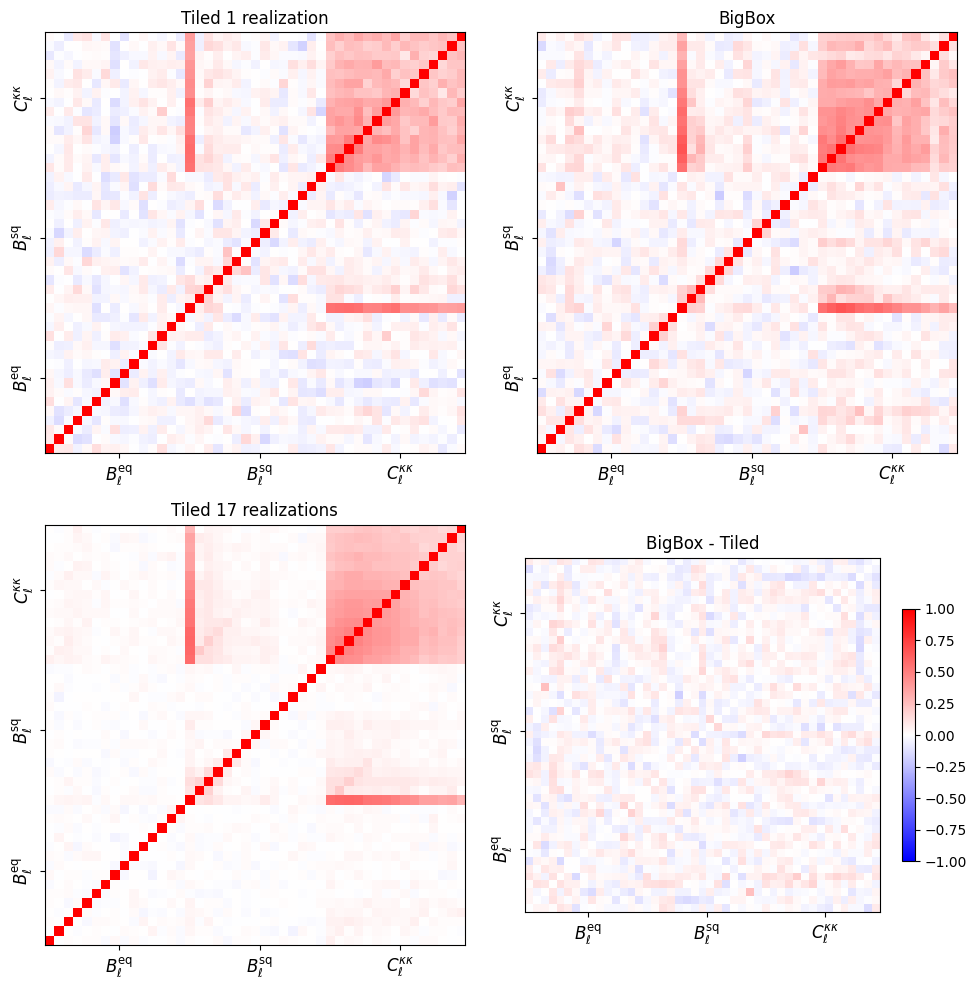

In [19]:
labels = [r'$B_{\ell}^\mathrm{eq}$', 
          r'$B_{\ell}^\mathrm{sq}$', 
          r'$C^{\kappa\kappa}_{\ell}$']

tick_positions = [nbin/2 + nbin * i for i in range(len(labels))]

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].imshow(corr_tiled_s100[:nbin *3, :nbin *3], cmap='bwr', vmin=-1, vmax=1)
ax[0, 0].set_title("Tiled 1 realization")

ax[1, 0].imshow(corr_tiled[:nbin *3, :nbin *3], cmap='bwr', vmin=-1, vmax=1)
ax[1, 0].set_title(f"Tiled {len(datas)} realizations")

ax[0, 1].imshow(corr_bigbox[:nbin *3, :nbin *3], cmap='bwr', vmin=-1, vmax=1)
ax[0, 1].set_title("BigBox")

im = ax[1, 1].imshow(corr_bigbox[:nbin *3, :nbin *3] - corr_tiled[:nbin *3, :nbin *3], cmap='bwr', vmin=-1, vmax=1)
ax[1, 1].set_title("BigBox - Tiled")
fig.colorbar(im, ax=ax[1, 1], shrink=0.6)

for axes in ax.flatten():
    axes.set_xticks(tick_positions, labels, fontsize=12)
    axes.set_yticks(tick_positions, labels, fontsize=12, rotation=90, va='center')
    axes.invert_yaxis()

plt.tight_layout()
plt.show()

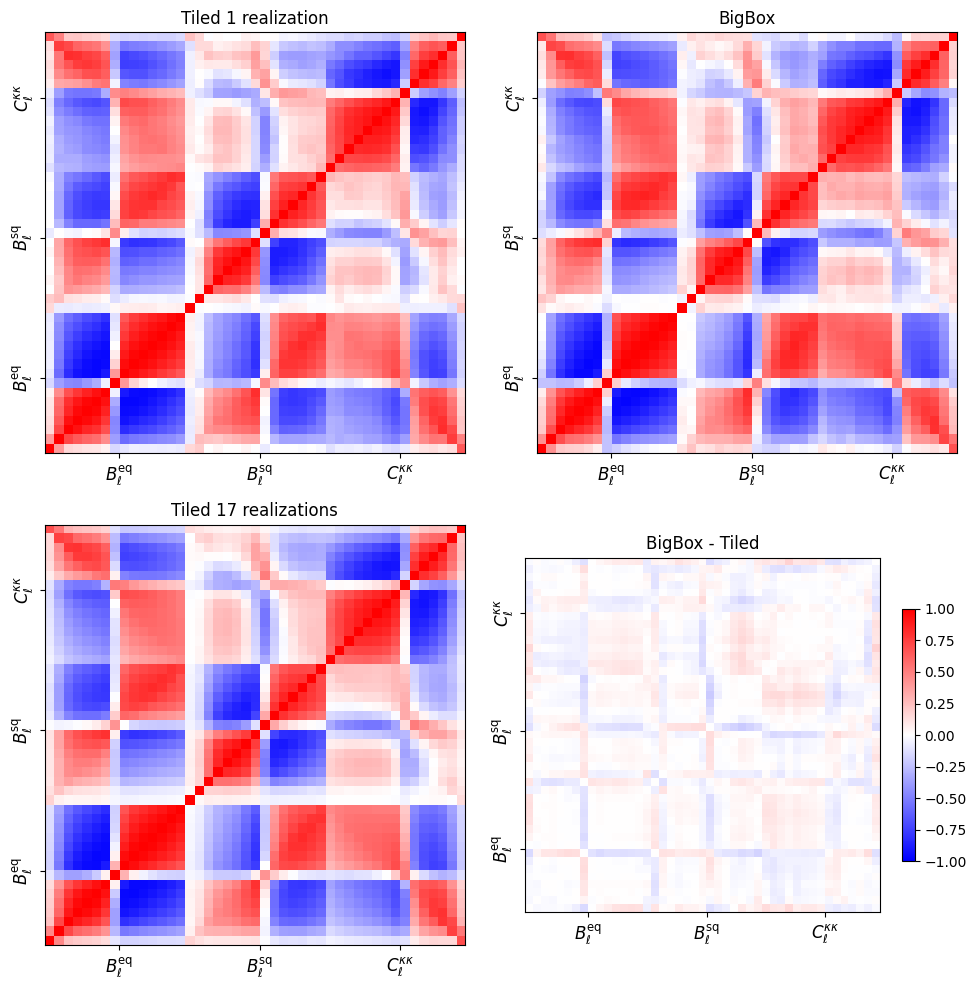

In [20]:
labels = [r'$B_{\ell}^\mathrm{eq}$', 
          r'$B_{\ell}^\mathrm{sq}$', 
          r'$C^{\kappa\kappa}_{\ell}$']

tick_positions = [nbin/2 + nbin * i for i in range(len(labels))]

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].imshow(corr_tiled_s100[nbin *3:, nbin *3:], cmap='bwr', vmin=-1, vmax=1)
ax[0, 0].set_title("Tiled 1 realization")

ax[1, 0].imshow(corr_tiled[nbin *3:, nbin *3:], cmap='bwr', vmin=-1, vmax=1)
ax[1, 0].set_title(f"Tiled {len(datas)} realizations")

ax[0, 1].imshow(corr_bigbox[nbin *3:, nbin *3:], cmap='bwr', vmin=-1, vmax=1)
ax[0, 1].set_title("BigBox")

im = ax[1, 1].imshow(corr_bigbox[nbin *3:, nbin *3:] - corr_tiled[nbin *3:, nbin *3:], cmap='bwr', vmin=-1, vmax=1)
ax[1, 1].set_title("BigBox - Tiled")
fig.colorbar(im, ax=ax[1, 1], shrink=0.6)

for axes in ax.flatten():
    axes.set_xticks(tick_positions, labels, fontsize=12)
    axes.set_yticks(tick_positions, labels, fontsize=12, rotation=90, va='center')
    axes.invert_yaxis()

plt.tight_layout()
plt.show()

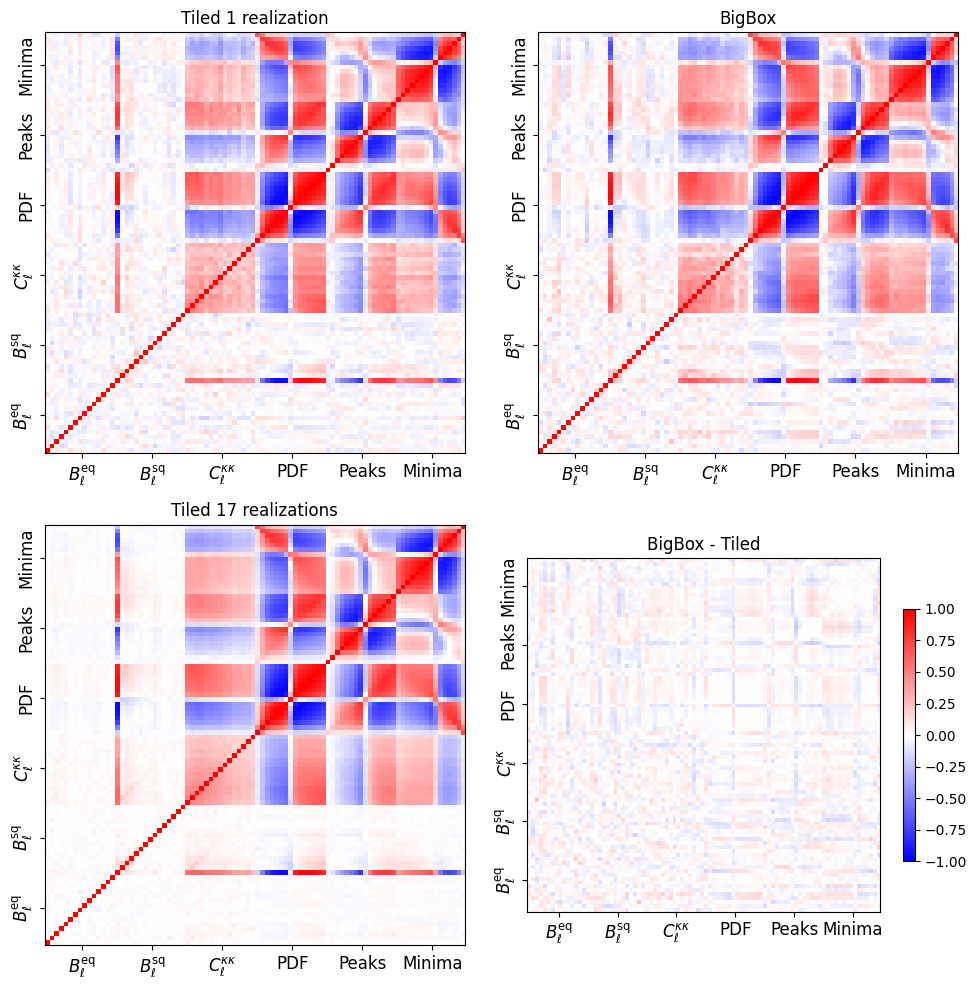

In [17]:
labels = [r'$B_{\ell}^\mathrm{eq}$', 
          r'$B_{\ell}^\mathrm{sq}$', 
          r'$C^{\kappa\kappa}_{\ell}$', 
          "PDF",
          "Peaks",
          "Minima"]

tick_positions = [nbin/2 + nbin * i for i in range(len(labels))]

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].imshow(corr_tiled_s100, cmap='bwr', vmin=-1, vmax=1)
ax[0, 0].set_title("Tiled 1 realization")

ax[1, 0].imshow(corr_tiled, cmap='bwr', vmin=-1, vmax=1)
ax[1, 0].set_title(f"Tiled {len(datas)} realizations")

ax[0, 1].imshow(corr_bigbox, cmap='bwr', vmin=-1, vmax=1)
ax[0, 1].set_title("BigBox")

im = ax[1, 1].imshow(corr_bigbox - corr_tiled, cmap='bwr', vmin=-1, vmax=1)
ax[1, 1].set_title("BigBox - Tiled")
fig.colorbar(im, ax=ax[1, 1], shrink=0.6)

for axes in ax.flatten():
    axes.set_xticks(tick_positions, labels, fontsize=12)
    axes.set_yticks(tick_positions, labels, fontsize=12, rotation=90, va='center')
    axes.invert_yaxis()

plt.tight_layout()
plt.show()

In [187]:
hf = np.load("/lustre/work/akira.tokiwa/Projects/LensingSSC/results/halofit/kappa_zs1.0_Clkk_ell_0_3000.npz")
ell_hf, cl_hf = hf['ell'], hf['clkk']
dcl_hf = dimensionless_cl(cl_hf, ell_hf)

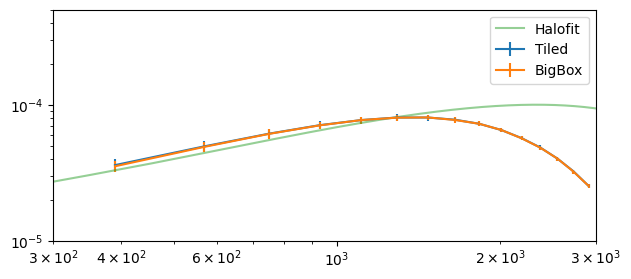

In [188]:
fig = plt.figure(figsize=(7, 3))
plt.errorbar(ell, clkk_tiled, yerr= clkk_std_tiled, label="Tiled")
plt.errorbar(ell, clkk_bigbox, yerr= clkk_std_bigbox, label="BigBox")
plt.plot(ell_hf, dcl_hf, label="Halofit", alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlim(300, 3000)
plt.ylim(1e-5, 5 * 1e-4)
plt.legend()
plt.show()

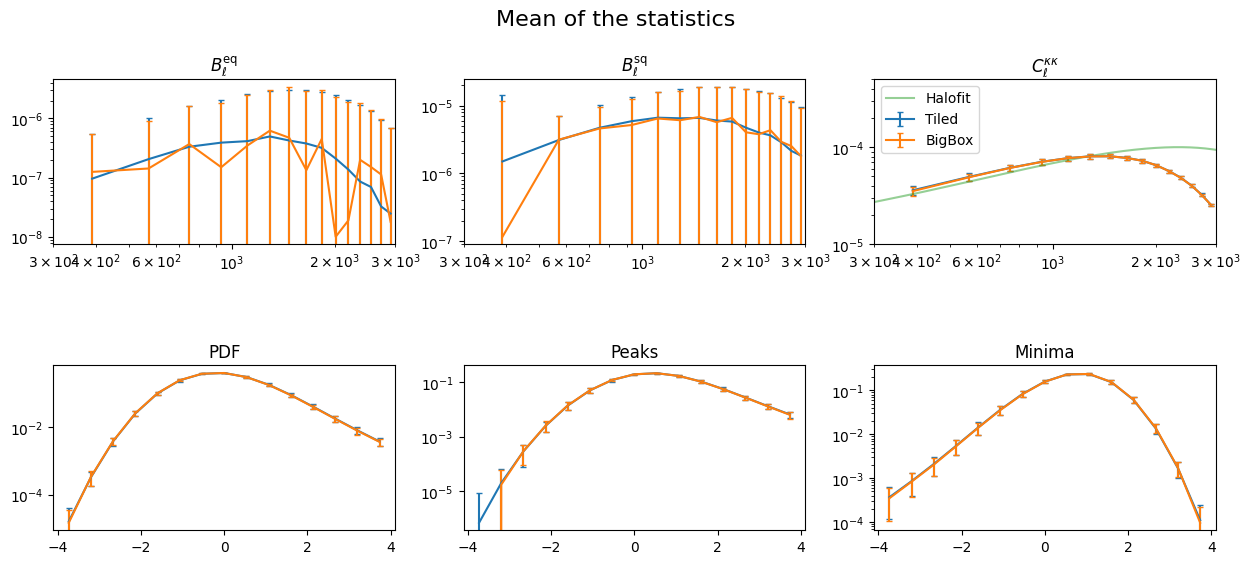

In [200]:
from matplotlib.gridspec import GridSpec

# Create the figure and GridSpec layout
fig = plt.figure(figsize=(15, 7))
gs = GridSpec(4, 3, height_ratios=[3, 1, 3, 1], hspace=0.3)

axes = [fig.add_subplot(gs[0, i]) for i in range(3)] + [fig.add_subplot(gs[2, i]) for i in range(3)]

for i, label in enumerate(labels):
    ax = axes[i]
    if i < 3:
        ax.errorbar(ell, mean_tiled[i*15:i*15+15], yerr=std_tiled[i*15:i*15+15], label="Tiled", capsize=2)
        ax.errorbar(ell, mean_bigbox[i*15:i*15+15], yerr=std_bigbox[i*15:i*15+15], label="BigBox", capsize=2, c="tab:orange")
        if i == 2:
            ax.plot(ell_hf, dcl_hf, label="Halofit", alpha=0.5, c="tab:green")
            ax.set_ylim(1e-5, 5 * 1e-4)
            ax.legend()

        ax.set_title(label)
        ax.set_xlim(300, 3000)
        ax.set_yscale('log')
        ax.set_xscale('log')
    else:
        ax.errorbar(b, mean_tiled[i*15:i*15+15], yerr=std_tiled[i*15:i*15+15], label="Tiled", capsize=2)
        ax.errorbar(b, mean_bigbox[i*15:i*15+15], yerr=std_bigbox[i*15:i*15+15], label="BigBox", capsize=2, c="tab:orange")
        ax.set_title(label)
        ax.set_yscale('log')

# set the title of this figure
fig.suptitle("Mean of the statistics", fontsize=16)
plt.show()

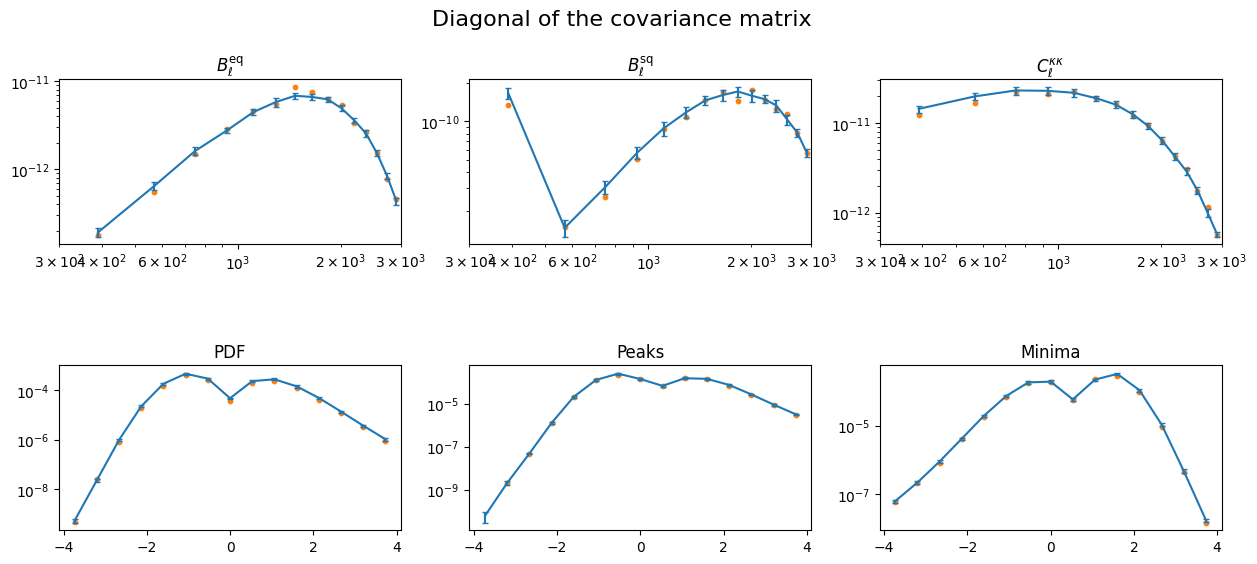

In [201]:
# Create the figure and GridSpec layout
fig = plt.figure(figsize=(15, 7))
gs = GridSpec(4, 3, height_ratios=[3, 1, 3, 1], hspace=0.3)

axes = [fig.add_subplot(gs[0, i]) for i in range(3)] + [fig.add_subplot(gs[2, i]) for i in range(3)]

for i, label in enumerate(labels):
    ax = axes[i]
    if i < 3:
        ax.errorbar(ell, diag_tiled[i*15:i*15+15], yerr=diags_std_tiled[i*15:i*15+15], label="Tiled", capsize=2)
        ax.scatter(ell, diag_bigbox[i*15:i*15+15], label="BigBox", s=10, c='tab:orange')    

        ax.set_title(label)
        ax.set_xlim(300, 3000)
        ax.set_yscale('log')
        ax.set_xscale('log')
    else:
        ax.errorbar(b, diag_tiled[i*15:i*15+15], yerr=diags_std_tiled[i*15:i*15+15], label="Tiled", capsize=2)
        ax.scatter(b, diag_bigbox[i*15:i*15+15], label="BigBox", s=10, c='tab:orange')
        ax.set_title(label)
        ax.set_yscale('log')

# set the title of this figure
fig.suptitle("Diagonal of the covariance matrix", fontsize=16)
plt.show()